In [7]:
import pandas as pd

matches_df = pd.read_csv("datasets/WorldCupMatches.csv")
players_df = pd.read_csv("datasets/WorldCupPlayers.csv")
worldcups_df = pd.read_csv("datasets/WorldCups.csv")

print("=== WorldCupMatches Columns ===")
print(matches_df.columns)

print("=== WorldCupPlayers Columns ===")
print(players_df.columns)

print("=== WorldCups Columns ===")
print(worldcups_df.columns)

=== WorldCupMatches Columns ===
Index(['Year', 'Datetime', 'Stage', 'Stadium', 'City', 'Home Team Name',
       'Home Team Goals', 'Away Team Goals', 'Away Team Name',
       'Win conditions', 'Attendance', 'Half-time Home Goals',
       'Half-time Away Goals', 'Referee', 'Assistant 1', 'Assistant 2',
       'RoundID', 'MatchID', 'Home Team Initials', 'Away Team Initials'],
      dtype='object')
=== WorldCupPlayers Columns ===
Index(['RoundID', 'MatchID', 'Team Initials', 'Coach Name', 'Line-up',
       'Shirt Number', 'Player Name', 'Position', 'Event'],
      dtype='object')
=== WorldCups Columns ===
Index(['Year', 'Country', 'Winner', 'Runners-Up', 'Third', 'Fourth',
       'GoalsScored', 'QualifiedTeams', 'MatchesPlayed', 'Attendance'],
      dtype='object')


# Data Pre-Processing

In [8]:
matches_df.dropna(how='all', inplace=True)
matches_df = matches_df.dropna(subset=['Year'])
matches_df['Year'] = matches_df['Year'].astype(int)
matches_df['Datetime'] = pd.to_datetime(matches_df['Datetime'], errors='coerce')

goal_cols = ['Home Team Goals', 'Away Team Goals', 'Half-time Home Goals', 'Half-time Away Goals']
matches_df[goal_cols] = matches_df[goal_cols].astype('Int64')

matches_df['Attendance'] = pd.to_numeric(matches_df['Attendance'], errors='coerce').round().astype('Int64')

matches_df['Home Team Name'] = matches_df['Home Team Name'].str.strip()
matches_df['Away Team Name'] = matches_df['Away Team Name'].str.strip()

players_df['Shirt Number'] = pd.to_numeric(players_df['Shirt Number'], errors='coerce')

worldcups_df['Attendance'] = worldcups_df['Attendance'].replace('[\.,]', '', regex=True).astype(int)
worldcups_df['Year'] = worldcups_df['Year'].astype(int)

# Feature Engineering

### Creating a new match winner column

In [10]:
def get_match_winner(row):
    if row['Home Team Goals'] > row['Away Team Goals']:
        return 'Home'
    elif row['Home Team Goals'] < row['Away Team Goals']:
        return 'Away'
    else:
        return 'Draw'

matches_df['match_winner'] = matches_df.apply(get_match_winner, axis=1)
matches_df['goal_difference'] = (matches_df['Home Team Goals'] - matches_df['Away Team Goals']).abs()
matches_df['total_goals'] = matches_df['Home Team Goals'] + matches_df['Away Team Goals']

print(matches_df[['Year', 'Home Team Name', 'Away Team Name', 'Home Team Goals', 'Away Team Goals', 'match_winner', 'goal_difference', 'total_goals']].head())

   Year Home Team Name Away Team Name  Home Team Goals  Away Team Goals  \
0  1930         France         Mexico                4                1   
1  1930            USA        Belgium                3                0   
2  1930     Yugoslavia         Brazil                2                1   
3  1930        Romania           Peru                3                1   
4  1930      Argentina         France                1                0   

  match_winner  goal_difference  total_goals  
0         Home                3            5  
1         Home                3            3  
2         Home                1            3  
3         Home                2            4  
4         Home                1            1  


# EDA

### Analyzing trends in match outcomes

In [11]:
win_trend = matches_df.groupby(['Year', 'match_winner']).size().unstack().fillna(0)
print(win_trend.tail())

match_winner  Away  Draw  Home
Year                          
1998          17.0  19.0  28.0
2002          21.0  16.0  27.0
2006          17.0  15.0  32.0
2010          25.0  16.0  23.0
2014          26.0  17.0  37.0


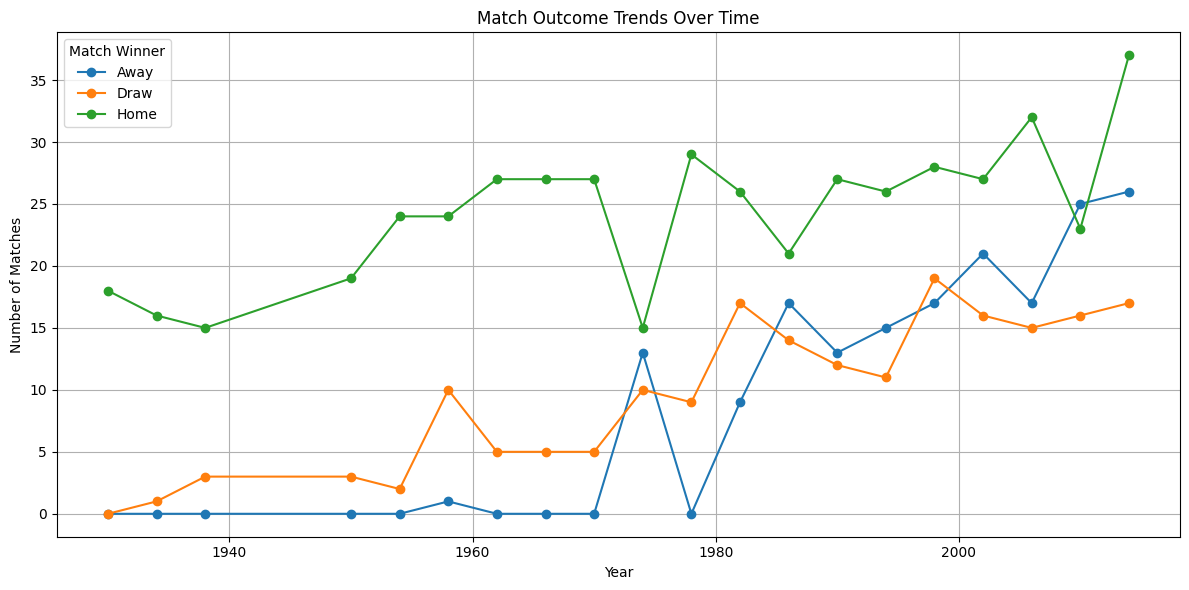

In [12]:
import matplotlib.pyplot as plt

win_trend.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Match Outcome Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Matches')
plt.grid(True)
plt.legend(title='Match Winner')
plt.tight_layout()
plt.show()

### Percentage of Matches in terms of Home wins, Away wins and Draws

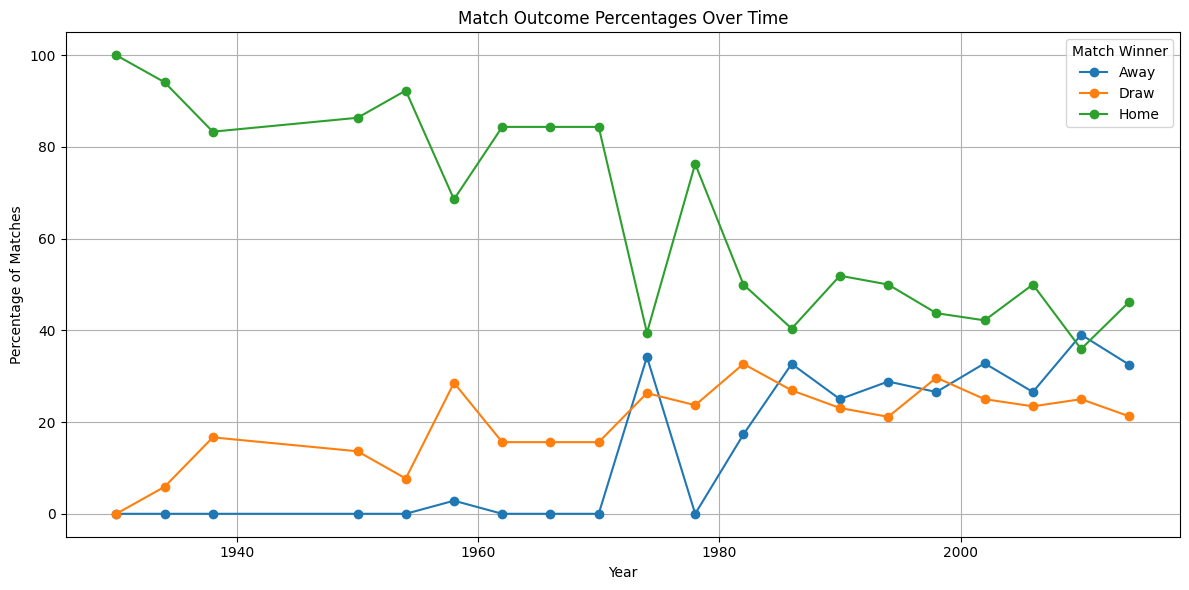

In [13]:
win_trend_percent = win_trend.div(win_trend.sum(axis=1), axis=0) * 100

win_trend_percent.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Match Outcome Percentages Over Time')
plt.ylabel('Percentage of Matches')
plt.xlabel('Year')
plt.grid(True)
plt.legend(title='Match Winner')
plt.tight_layout()
plt.show()

### Looking at if draws occur more often in the group stage or the knockout stages

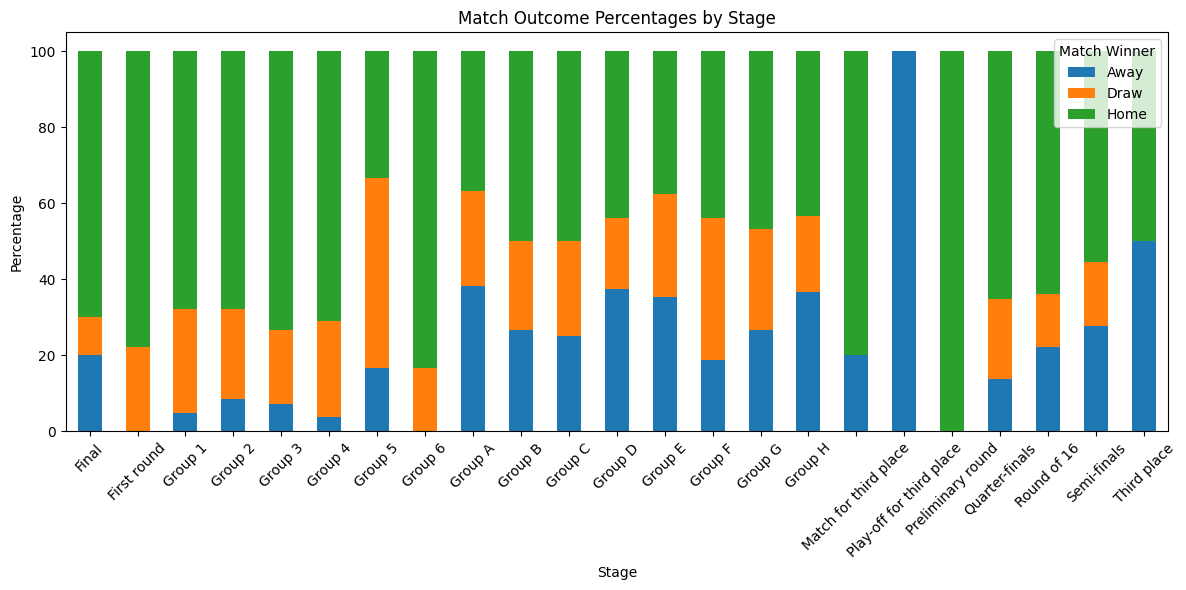

In [14]:
stage_wins = matches_df.groupby(['Stage', 'match_winner']).size().unstack().fillna(0)
stage_wins_percent = stage_wins.div(stage_wins.sum(axis=1), axis=0) * 100
stage_wins_percent.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Match Outcome Percentages by Stage')
plt.ylabel('Percentage')
plt.xlabel('Stage')
plt.xticks(rotation=45)
plt.legend(title='Match Winner')
plt.tight_layout()
plt.show()

### Which countries win the most matches?

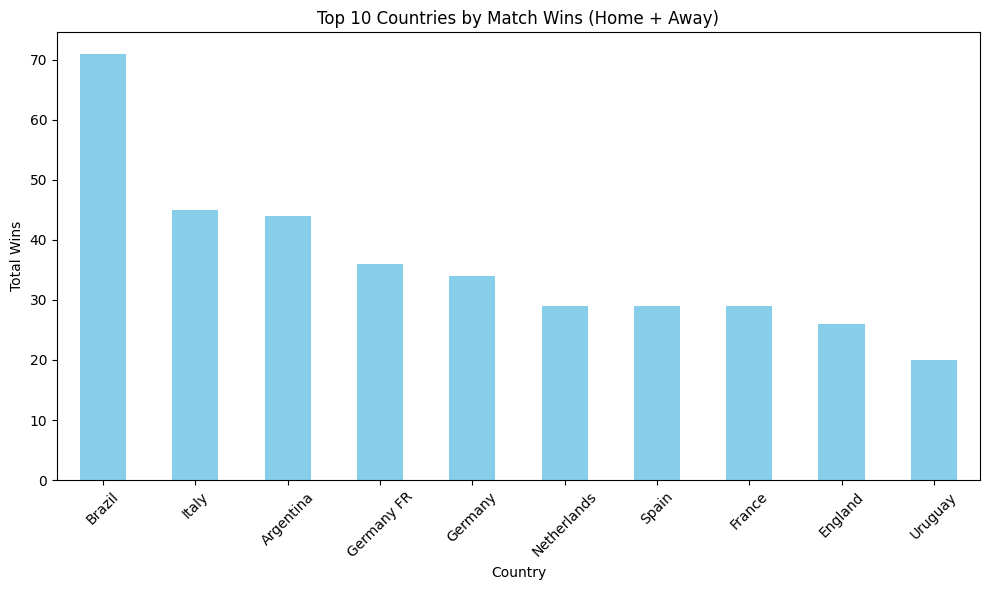

In [15]:
home_wins = matches_df[matches_df['match_winner'] == 'Home']['Home Team Name'].value_counts()
away_wins = matches_df[matches_df['match_winner'] == 'Away']['Away Team Name'].value_counts()

total_wins = (home_wins + away_wins).sort_values(ascending=False).head(10)
total_wins.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Top 10 Countries by Match Wins (Home + Away)')
plt.ylabel('Total Wins')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()